# **Face Recognition Project**

### Загрузка и предобработка данных

In [1]:
import requests
from urllib.parse import urlencode
import numpy as np

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/S8f03spLIA1wrw'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('downloaded_file.zip', 'wb') as f:
    f.write(download_response.content)

Разархивируем downloaded_file.zip

In [3]:
import zipfile

with zipfile.ZipFile('downloaded_file.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

Удалим ненужные файлы

In [4]:
import os

filename = 'downloaded_file.zip'

# Если файл существует, удаляем
if os.path.exists(filename):
    os.remove(filename)
    print(filename + " deleted")

downloaded_file.zip deleted


In [5]:
import shutil

filename = '/content/extracted_files/__MACOSX'

# Если файл существует, удаляем
if os.path.exists(filename):
    shutil.rmtree(filename)
    print(filename + " deleted")

/content/extracted_files/__MACOSX deleted


    Внутри:
            - celebA_imgs — папка с выровненными картинками;
            - celebA_anno.txt — файл с аннотацией — каждой картинке из celebA_imgs поставлен в соответствие ее id;
            - celebA_train_split.txt — файл со сплитом на train/val/test.

In [6]:
import pandas as pd

In [7]:
from PIL import Image
import torch
from torch.utils.data import Dataset

from matplotlib import pyplot as plt

In [8]:
data_modes = ["train", "val", "test"]

In [9]:
from torchvision import transforms, models

Создадим custom Dataset для подготовки данных

In [10]:
class CelebADataset(Dataset):
    def __init__(self, img_dir, anno_file, split_file, mode):
        self.mode = mode
        if self.mode not in data_modes:
            print(f"{self.mode} is not correct; correct modes: {data_modes}")
            raise NameError
        self.img_dir = img_dir
        self.anno = pd.read_csv(anno_file, sep='\s+', header=None)
        self.train_split = pd.read_csv(split_file, sep='\s+', header=None)

        if mode == "train":
            self.img_ids = self.train_split[self.train_split[1] == 0][0].values
            self.labels = {img_id: label for img_id, label in self.anno[self.anno[0].isin(self.img_ids)].values}
        elif mode == "val":
            self.img_ids = self.train_split[self.train_split[1] == 1][0].values
            self.labels = {img_id: label for img_id, label in self.anno[self.anno[0].isin(self.img_ids)].values}
        else:
            self.img_ids = self.train_split[self.train_split[1] == 2][0].values
            self.labels = {img_id: label for img_id, label in self.anno[self.anno[0].isin(self.img_ids)].values}

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_path = os.path.join(self.img_dir, img_id)
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # mean and std of Imagenet
        ])

        image = np.array(Image.open(img_path))
        image = Image.fromarray(image[77:-41, 45:-50])
        image = image.resize((224, 224))
        image = np.array(image)
        image = np.array(image / 255, dtype='float32')
        image = transform(image)

        label = self.labels[img_id]
        return image, label

In [11]:
img_dir="/content/extracted_files/celebA_train_500/celebA_imgs"
anno_file="/content/extracted_files/celebA_train_500/celebA_anno.txt"
split_file="/content/extracted_files/celebA_train_500/celebA_train_split.txt"

tr_dataset = CelebADataset(
    img_dir=img_dir,
    anno_file=anno_file,
    split_file=split_file,
    mode="train"
)
val_dataset = CelebADataset(
    img_dir=img_dir,
    anno_file=anno_file,
    split_file=split_file,
    mode="val"
)
test_dataset = CelebADataset(
    img_dir=img_dir,
    anno_file=anno_file,
    split_file=split_file,
    mode="test"
)

Напишем функцию для вывода картинки

In [12]:
def imshow(inp, plt_ax=plt):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.axis(False)
    plt_ax.imshow(inp)

И теперь посмотрим на лица в нашем датасете

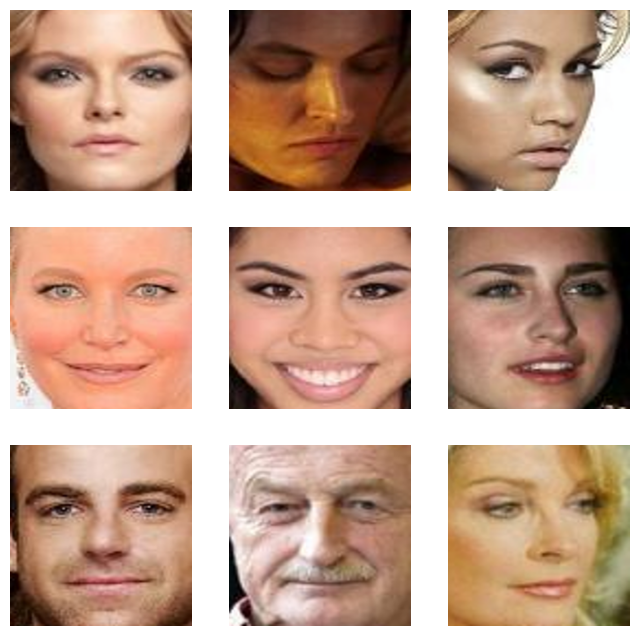

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for ax in axes.flatten():
    rand_person = int(np.random.uniform(0, val_dataset.__len__()))
    im_val, label = val_dataset[rand_person]
    imshow(im_val.data.cpu(), plt_ax=ax)

### Обучение модели

In [14]:
from torch.utils.data import DataLoader

In [15]:
import torch.nn as nn

In [16]:
tr_dataloader = DataLoader(tr_dataset, batch_size=32, num_workers=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=2, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=2, shuffle=False)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Напишем функцию обучения

In [18]:
def train(train_data, val_data, model, optimizer, criterion, epochs):
    history = []
    optimizer = optimizer
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_loss_per_epoch = []
        running_corrects = 0
        processed_data = 0
        for X_batch, y_batch in train_data:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            preds = torch.argmax(outputs, 1)

            train_loss_per_epoch.append(loss.item())
            running_corrects += torch.sum(preds == y_batch)
            processed_data += y_batch.size(0)
        train_loss = np.mean(train_loss_per_epoch)
        train_acc = running_corrects / processed_data

        model.eval()
        val_loss_per_epoch = []
        running_corrects = 0
        processed_data = 0
        for X_batch, y_batch in val_data:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            with torch.no_grad():
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                preds = torch.argmax(outputs, 1)
            val_loss_per_epoch.append(loss.item())
            running_corrects += torch.sum(preds == y_batch)
            processed_data += y_batch.size(0)

        val_loss = np.mean(val_loss_per_epoch)
        val_acc = running_corrects / processed_data

        history.append((train_loss, train_acc, val_loss, val_acc))
        print(f"Epoch: {epoch+1} train_loss: {train_loss} val_loss: {val_loss} \
        train_acc: {train_acc} val_acc: {val_acc}")

    return history

In [19]:
# model = models.resnet50(weights="IMAGENET1K_V2")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 134MB/s]


Определим количество классов в датасете и изменим последний слой сети

In [31]:
model = models.efficientnet_b6(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/efficientnet_b6_lukemelas-24a108a5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b6_lukemelas-24a108a5.pth
100%|██████████| 165M/165M [00:01<00:00, 171MB/s]


In [20]:
n_classes = len(pd.read_csv(anno_file, sep='\s+', header=None)[1].unique())
n_classes

500

In [37]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [36]:
model.classifier[1] = nn.Linear(2304, n_classes)

In [21]:
# model.fc = nn.Linear(2048, n_classes)

Теперь обучим модель на Cross-Entropy Loss

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [24]:
history = train(tr_dataloader, val_dataloader, model, optimizer, loss_fn, 15)

Epoch: 1 train_loss: 6.042102247588197 val_loss: 5.385796199410649         train_acc: 0.010533708147704601 val_acc: 0.04472843557596207
Epoch: 2 train_loss: 4.208060265480356 val_loss: 3.3701550920130843         train_acc: 0.20177902281284332 val_acc: 0.31416401267051697
Epoch: 3 train_loss: 2.1805431753508606 val_loss: 2.407458529633991         train_acc: 0.5586376190185547 val_acc: 0.4893503785133362
Epoch: 4 train_loss: 0.9816730273573586 val_loss: 2.0574771670971885         train_acc: 0.8321629166603088 val_acc: 0.5500532388687134
Epoch: 5 train_loss: 0.3668563292267617 val_loss: 1.9264048014656971         train_acc: 0.9632490873336792 val_acc: 0.579872190952301
Epoch: 6 train_loss: 0.11599146424049742 val_loss: 1.8321979692426777         train_acc: 0.9960206151008606 val_acc: 0.6006389856338501
Epoch: 7 train_loss: 0.04592364988104904 val_loss: 1.7868575857857527         train_acc: 1.0 val_acc: 0.6123535633087158
Epoch: 8 train_loss: 0.02689577948846174 val_loss: 1.781270942445528

KeyboardInterrupt: 

In [26]:
train_loss, train_acc, val_loss, val_acc = zip(*history)

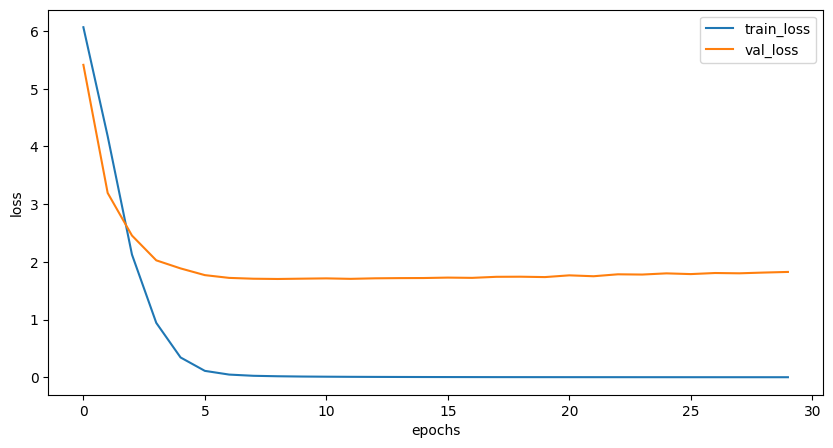

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

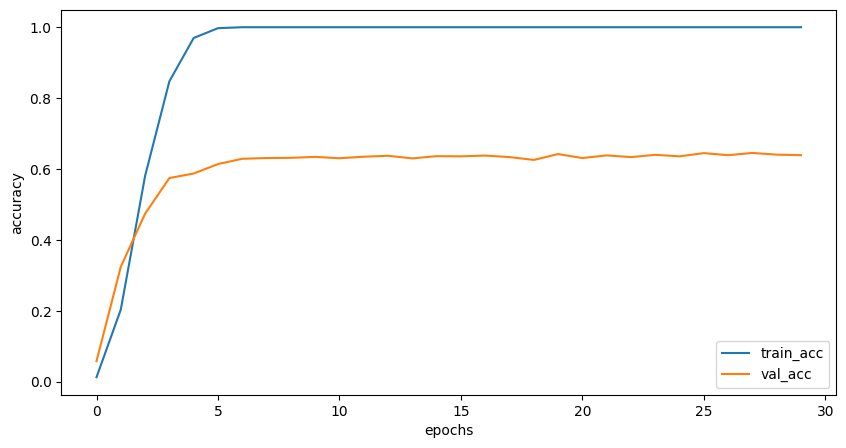

In [28]:
train_acc = [acc.cpu() for acc in train_acc]
val_acc = [acc.cpu() for acc in val_acc]

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

Инференс

In [29]:
def score_model(model, data):
    model.eval()
    correct = 0
    processed_data = 0
    for X_batch, y_batch in data:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        with torch.no_grad():
            outputs = model(X_batch)
            preds = torch.argmax(outputs, 1)
        correct += torch.sum(preds == y_batch)
        processed_data += y_batch.size(0)
    acc = correct / processed_data
    return acc

In [40]:
print(f"Accuracy модели на Cross-Entropy Loss: {score_model(model, test_dataloader)}")

Accuracy модели на Cross-Entropy Loss: 0.7149150371551514
